### Fake News Classification SMOTE

In [ ]:
## Load Pkgs
import numpy as np
import pandas as pd

# Load ML Pkgs
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import metrics

# spaCy based imports
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
!python -m spacy download en_core_web_lg
nlp = spacy.load('en')
nlp = spacy.load('en_core_web_sm')
# Creating a Spacy Parser
parser = English()

# Use the punctuations of string module
import re,string,unicodedata
punctuations = string.punctuation
from imblearn.over_sampling import SMOTE

# Plotly based imports for visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from wordcloud import WordCloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 827.9 MB 1.4 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=40e93ee20ed7d86bbfdc01052e47083bc152659b0741d011635d1bd79e7b018f
  Stored in directory: /tmp/pip-ephem-wheel-cache-kf_2x57c/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
#Cargo las BBDD
from google.colab import files
true = pd.read_csv("True.csv")

In [ ]:
fake = pd.read_csv("Fake.csv")

In [ ]:
#Observo las categorías
true.shape,fake.shape

((21417, 4), (23481, 4))

In [ ]:
# Muestra 80-20
fake = fake[0:23481]
true = true.sample(n=5870, random_state=42)

In [ ]:
#Asigno etiqueta a cada categoría
true['category'] = 1
fake['category'] = 0

df = pd.concat([true,fake])

In [ ]:
#Data Frame final
df.shape

(29351, 5)

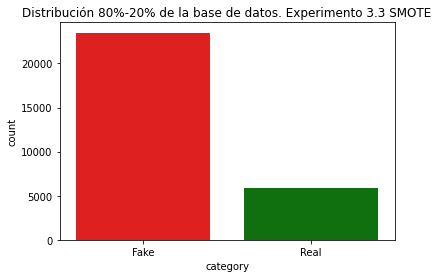

In [ ]:
#Grafico para ver la distribución
plt.figure(figsize=(6,4))
ax = sns.countplot(x="category", data=df)
plt.title('Distribución 80%-20% de la base de datos. Experimento 3.3 SMOTE') 
ax.set_xticklabels(['Fake','Real'], rotation=0)
color = ["Red", "Green"] 
sns.set_palette(color)
plt.show()

In [ ]:
#Eliminación de caracteres especiales y puntuación
df['text'] = df['text'].apply(lambda x: re.sub('[^a-z A-Z 0-9-]+', '', x))

In [ ]:
contractions = {
"aight": "alright","ain't": "am not","amn't": "am not","aren't": "are not",
"can't": "can not","cause": "because","could've": "could have",
"couldn't": "could not","couldn't've": "could not have","daren't": "dare not",
"daren't": "dared not","daresn't": "dare not","dasn't": "dare not",
"didn't": "did not","doesn't": "does not","don't": "do not","don't": "does not",
"d'ye": "do you","d'ye": "did you","e'er": "ever","everybody's": "everybody is",
"everyone's": "everyone is","finna": "fixing to","finna": "going to",
"g'day": "good day","gimme": "give me","giv'n": "given","gonna": "going to",
"gon't": "go not","gotta": "got to","hadn't": "had not","had've": "had have",
"hasn't": "has not","haven't": "have not","he'd": "he had","he'd": "he would",
"he'dn't've'd": "he would not have had","he'll": "he shall",
"he'll": "he will","he's": "he has","he's": "he is","he've": "he have",
"how'd": "how did","how'd": "how would","howdy": "how do you do",
"howdy": "how do you fare","how'll": "how will","how're": "how are",
"I'll": "I shall","I'll": "I will","I'm": "I am","I'm'a": "I am about to",
"I'm'o": "I am going to","innit": "is it not","I've": "I have",
"isn't": "is not","it'd": "it would","it'll": "it shall","it'll": "it will",
"it's": "it has","it's": "it is","let's": "let us","ma'am": "madam",
"mayn't": "may not","may've": "may have","methinks": "me thinks",
"mightn't": "might not","might've": "might have","mustn't": "must not",
"mustn't've": "must not have","must've": "must have","needn't": "need not",
"ne'er": "never","o'clock": "of the clock","o'er": "over","ol'": "old",
"oughtn't": "ought not","'s": "is, has, does, or us","shalln't": "shall not",
"shan't": "shall not","she'd": "she had","she'd": "she would",
"she'll": "she shall","she'll": "she will","she's": "she has","she's": "she is",
"should've": "should have","shouldn't": "should not",
"shouldn't've": "should not have","somebody's": "somebody has",
"somebody's": "somebody is","someone's": "someone has",
"someone's": "someone is","something's": "something has",
"something's": "something is","so're": "so are","that'll": "that shall",
"that'll": "that will","that're": "that are","that's": "that has",
"that's": "that is","that'd": "that would","that'd": "that had",
"there'd": "there had","there'd": "there would","there'll": "there shall",
"there'll": "there will","there're": "there are","there's": "there has",
"there's": "there is","these're": "these are","these've": "these have",
"they'd": "they had","they'd": "they would","they'll": "they shall",
"they'll": "they will","they're": "they are","they're": "they were",
"they've": "they have","this's": "this has","this's": "this is",
"those're": "those are","those've": "those have","'tis": "it is",
"to've": "to have","'twas": "it was","wanna": "want to","wasn't": "was not",
"we'd": "we had","we'd": "we would","we'd": "we did","we'll": "we shall",
"we'll": "we will","we're": "we are","we've": "we have","weren't": "were not",
"what'd": "what did","what'll": "what shall","what'll": "what will",
"what're": "what are","what're": "what were","what's": "what has",
"what's": "what is","what's": "what does","what've": "what have",
"when's": "when has","when's": "when is","where'd": "where did",
"where'll": "where shall","where'll": "where will","where're": "where are",
"where's": "where has","where's": "where is","where's": "where does",
"where've": "where have","which'd": "which had","which'd": "which would",
"which'll": "which shall","which'll": "which will","which're": "which are",
"which's": "which has","which's": "which is","which've": "which have",
"who'd": "who would","who'd": "who had","who'd": "who did",
"who'd've": "who would have","who'll": "who shall","who'll": "who will",
"who're": "who are","who's": "who has","who's": "who is",
"who's": "who does","who've": "who have","why'd": "why did",
"why're": "why are","why's": "why has","why's": "why is","why's": "why does",
"won't": "will not","would've": "would have","wouldn't": "would not",
"wouldn't've": "would not have","y'all": "you all",
"y'all'd've": "you all would have",
"y'all'dn't've'd": "you all would not have had","y'all're": "you all are",
"you'd": "you had","you'd": "you would","you'll": "you shall",
"you'll": "you will","you're": "you are","you're": "you are",
"you've": "you have"," u ": "you"," ur ": "your"," n ": "and"
}

In [ ]:
def cont_to_exp(x):
    if type(x) is str:
        for key in contractions:
            value = contractions[key]
            x = x.replace(key,value)
        return x
    else:
        return x

In [ ]:
# Construyo la lista de stopwords para filtrar
stopwords = list(STOP_WORDS)

In [ ]:
##Extracción de características
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    return mytokens

In [ ]:
#Transformador personalizado usando spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self, deep=True):
        return {}

In [ ]:
# Función básica para limpiar el texto
def clean_text(text):     
    return text.strip().lower()

In [ ]:
# Vectorización 
vectorizer = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1)) 
classifier = SVC() #por defecto el rbf= radial


In [ ]:
###### División de conjuntos de datos
# Características y etiquetas
x = df['text']
ylabels = df['category']
x_train, x_test, y_train, y_test = train_test_split(x, ylabels, test_size=0.2, random_state=42)
#####
x_train_vector = vectorizer.fit_transform(x_train)
x_test_vector = vectorizer.transform(x_test)

In [ ]:
x_train.shape

(23480,)

In [ ]:
# Cree la canalización para limpiar, tokenizar, vectorizar y clasifica
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', vectorizer),
                 ('classifier', classifier)])

In [ ]:
#Ajustar los datos
pipe.fit(x_train, y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7f1ab783c790>),
                ('vectorizer',
                 CountVectorizer(tokenizer=<function spacy_tokenizer at 0x7f1abaa17b90>)),
                ('classifier', SVC())])

In [ ]:
x_test.shape

(5871,)

### SMOTE

In [ ]:
# Llamo al algoritmo SMOTE
sm = SMOTE(random_state=42)
x_res, y_res = sm.fit_resample(x_train_vector, y_train)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'Fake'), Text(0, 0, 'Real')]

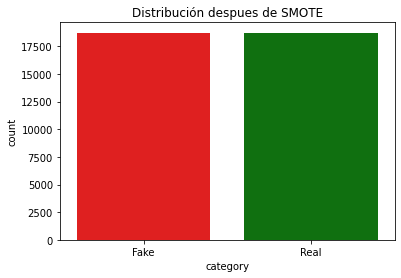

In [ ]:
# Grafico la nueva distribución
pd.Series(y_res).value_counts().plot(kind='bar', title='Distribución despues de SMOTE', color= ['red','green'])
ax = sns.countplot(y_res, data=df)
ax.set_xticklabels(['Fake','Real'], rotation=0)


In [ ]:
R = y_res.sum()
F = x_res.shape[0]- R
print(R, F)

18738 18738


In [ ]:
# SMOTE Random Forest
rfc = RandomForestClassifier(random_state = 42)
#Fitting the training data
rfc.fit(x_res, y_res)
#Predicting on test
y_pred_rfc=rfc.predict(x_test_vector)
print("Accuracy Score Random Forest:",rfc.score(x_test_vector, y_test))
print(classification_report(y_test, y_pred_rfc))



Accuracy Score Random Forest: 0.9799012093340147
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4743
           1       0.97      0.92      0.95      1128

    accuracy                           0.98      5871
   macro avg       0.98      0.96      0.97      5871
weighted avg       0.98      0.98      0.98      5871



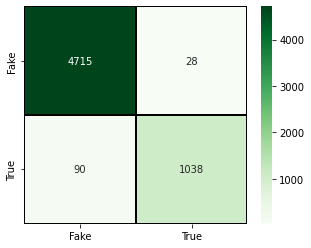

In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rfc),cmap= "Greens", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','True'] , yticklabels = ['Fake','True']);

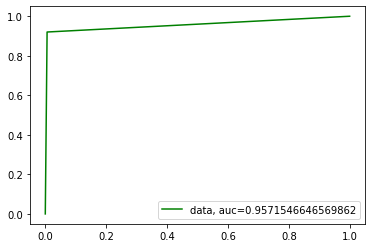

In [ ]:

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_rfc)
auc = metrics.roc_auc_score(y_test, y_pred_rfc)
plt.plot(fpr,tpr,label="data, auc="+str(auc), color=("green"))
plt.legend(loc=4)
plt.show()

In [ ]:
### Suport Vector Machine
#Fitting the training data
svc = SVC(kernel='linear', random_state = 42)
svc.fit(x_res, y_res)
#Predicting on test
y_pred_svc=svc.predict(x_test_vector)
print("Accuracy Score SVC:",svc.score(x_test_vector, y_test))
print(classification_report(y_test, y_pred_svc))

Accuracy Score SVC: 0.9843297564299097
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4743
           1       0.96      0.96      0.96      1128

    accuracy                           0.98      5871
   macro avg       0.97      0.98      0.97      5871
weighted avg       0.98      0.98      0.98      5871



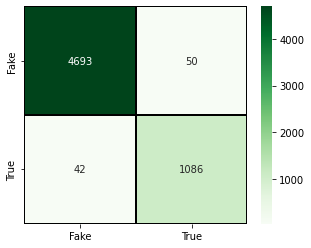

In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_svc),cmap= "Greens", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','True'] , yticklabels = ['Fake','True']);

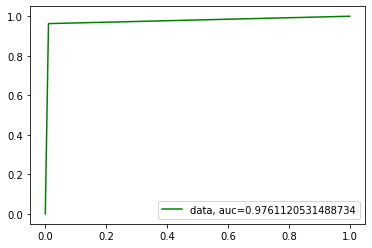

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_svc)
auc = metrics.roc_auc_score(y_test, y_pred_svc)
plt.plot(fpr,tpr,label="data, auc="+str(auc), color=("green"))
plt.legend(loc=4)
plt.show()

In [ ]:
##Gradient boosting
gbc = GradientBoostingClassifier(random_state = 42)
#Fitting the training data
gbc.fit(x_res, y_res)
#Predicting on test
y_pred_gbc=gbc.predict(x_test_vector)
print("Accuracy Score Gradient Boosting:",gbc.score(x_test_vector, y_test))
print(classification_report(y_test, y_pred_gbc))

Accuracy Score Gradient Boosting: 0.9928461931527849
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4743
           1       0.96      1.00      0.98      1128

    accuracy                           0.99      5871
   macro avg       0.98      1.00      0.99      5871
weighted avg       0.99      0.99      0.99      5871



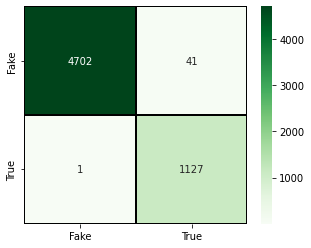

In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_gbc),cmap= "Greens", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','True'] , yticklabels = ['Fake','True']);

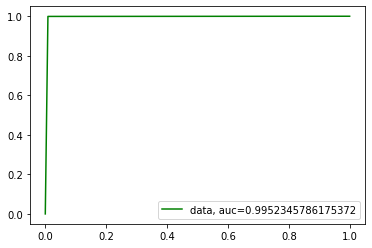

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_gbc)
auc = metrics.roc_auc_score(y_test, y_pred_gbc)
plt.plot(fpr,tpr,label="data, auc="+str(auc), color=("green"))
plt.legend(loc=4)
plt.show()